# SRE ReAct agent with custom schema and RAG (to store mitigation plans)

This notebook implements an intelligent Site Reliability Engineering (SRE) agent that automatically diagnoses Kubernetes incidents and generates mitigation plans. The agent uses a ReAct (Reasoning + Acting) framework powered by LangGraph to:

- **Investigate incidents** using kubectl tools through MCP (Model Context Protocol) servers
- **Analyze cluster state** and extract meaningful insights from Kubernetes resources
- **Generate structured diagnosis** with detailed reasoning and root cause analysis
- **Create mitigation plans** by leveraging ChromaDB RAG to search for similar past incidents
- **Provide comprehensive reports** with step-by-step remediation guidance

In [58]:
from dotenv import load_dotenv
import os

# Set env variables from file
load_dotenv()

True

In [26]:
chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

## Testing the RAG (ChromaDB)

In [27]:
from chromadb import PersistentClient

chroma_client = PersistentClient(path=chromaDB_path)

incidents_collection = chroma_client.get_or_create_collection("incidents")

# Get all the docs in the collection
incidents_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': []}

## Building SRE ReAct agent

In [28]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

In [29]:
from langchain_mcp_adapters.client import MultiServerMCPClient

chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "chroma": {
            "command": "uvx",
            "transport": "stdio",
            "args": [
                "chroma-mcp",
                "--client-type",
                "persistent",
                "--data-dir",
                str(chromaDB_path)
            ]
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}")

🔧 kubectl_get
🔧 kubectl_describe
🔧 kubectl_apply
🔧 kubectl_create
🔧 kubectl_logs
🔧 kubectl_scale
🔧 kubectl_patch
🔧 kubectl_rollout
🔧 kubectl_context
🔧 explain_resource
🔧 install_helm_chart
🔧 upgrade_helm_chart
🔧 port_forward
🔧 stop_port_forward
🔧 exec_in_pod
🔧 list_api_resources
🔧 ping
🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [31]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

tools = []
chroma_tools = []

for tool in mcp_tools:
    # Remove not allowed MCP tools
    if tool.name in tools_allowed:
        tools.append(tool)
    # Create a custom list for ChromaDB tools
    elif "chroma" in  tool.name:
        chroma_tools.append(tool)

In [32]:
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


In [33]:
# List of chromaDB tools
for tool in chroma_tools:
    print(f"🔧 {tool.name}")

🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [34]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str
    final_output: str
    mitigation_plan_overview: str
    mitigation_steps: List[str]
    is_already_happened: bool

In [35]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Begin by analyzing the service's state and telemetry using kubectl tools
        2. When you have identified the issue, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the issue you have identified (without fixing it)
            - reasoning: Explain your reasoning and thought process behind the solution

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [36]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. From the latest two messages, extract the most important new insight relevant for incident diagnosis or mitigation. Summarize it concisely.
    2. Write a concise description of only the most recent action taken including the tool used (not the whole list).  
"""

In [37]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

### Extract insights node

In [38]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [39]:
llm_with_strct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [40]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_strct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

### SRE Agent node

In [41]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"Diagnosis:\n{diagnosis}\n\nReasoning:\n{reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
tools_with_completion = tools + [completion_tool]

In [42]:
async def sreAgent(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"]
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(tools_with_completion, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [43]:
async def format_response(state: SREAgentState):
    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    message = "# 📝 Results of the Analysis\n\n"

    # Steps performed
    message += "## 🔍 Steps Performed\n"
    message += prev_step_str.strip() + "\n\n"

    # Insights
    message += "## 💡 Insights Gathered\n"
    message += insights_str.strip() + "\n\n"

    # Final root cause
    message += "## 🚨 Final Report (Root Cause)\n"
    message += f"> {state['response'].strip()}\n\n"

    # Mitigation overview
    message += "## 🛠️ Mitigation Plan Strategy\n"
    message += f"{state['mitigation_plan_overview'].strip()}\n\n"

    # Detailed mitigation steps
    message += "## 📋 Detailed Mitigation Steps\n"
    for i, step in enumerate(state["mitigation_steps"], start=1):
        message += f"{i}. {step}\n"

    return {"final_output": message}


### Elaborate mitigation plan

In [44]:
class MitigationPlanResponse(BaseModel):
    mitigation_steps: List[str] = Field(..., description="List of steps to be executed to mitigate the current incident")
    mitigation_plan_overview: str = Field(..., description="Short overview of the mitigation plan to be executed")
    is_previous_incident: bool = Field(..., description="True if the mitigation plan was found in the incidetns colletionc (incident already happened)")

In [45]:
mitigation_planner_prompt = """
    You're a React agent developed using the LangGraph prebuilt agent framework, in charge of creating a mitigation plan to solve an incident in a deployed Kubernetes infrastructure.
    
    Important: do not execute the mitigation plan, just explain all the steps.

    The root cause will be provided and then you should:
        1. Look using the ChromaDB tools if you find any similar incident in the 'incidents' collection.
        2. If so, set "is_previous_incident" to True and return the mitigation plan previously discovered if it fits for the current problem.
        3. If not, create a custom mitigation plan. Use Kubernetes tools only to check for more information, but try to avoid using them unless necessary.
    
    Report of the incident:
    {incident_report}
"""

In [46]:
mitigation_agent_tools = tools + chroma_tools
mitigation_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [47]:
from langgraph.prebuilt import create_react_agent

async def mitigation_planner(state: SREAgentState):

    # Create a React agent
    mitigation_agent = create_react_agent(
        name = "MitigationPlanGenerator",
        model = gpt5mini,
        tools = mitigation_agent_tools,
        prompt= mitigation_planner_prompt.format(incident_report = state["response"]),
        response_format = MitigationPlanResponse
    )

    mitigation_response = await mitigation_agent.ainvoke({})

    return {
        "mitigation_plan_overview" : mitigation_response['structured_response'].mitigation_plan_overview,
        "mitigation_steps" : mitigation_response['structured_response'].mitigation_steps,
        "is_already_happened" : mitigation_response['structured_response'].is_previous_incident
    }

In [48]:
async def store_incident_report(state: SREAgentState):
    """Store the incident report with the mitigation plan in chromaDB incidents collection"""

    from chromadb import PersistentClient
    import uuid

    chroma_client = PersistentClient(path=chromaDB_path)

    incidents_collection = chroma_client.get_or_create_collection("incidents")

    incidents_collection.add(
        ids=[str(uuid.uuid4)],
        documents=state["final_output"],
    )

    return {}

### Assemble the graph

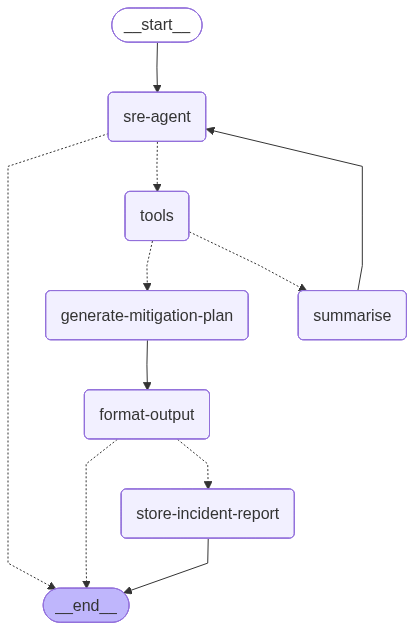

In [49]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(tools_with_completion)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("generate-mitigation-plan", mitigation_planner)
builder.add_node("format-output", format_response)
builder.add_node("store-incident-report", store_incident_report)

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return "generate-mitigation-plan"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "generate-mitigation-plan": "generate-mitigation-plan"
    }
)

# If is a new incident, store in VectorDB
def new_incident_condition(state: SREAgentState):
    if state['is_already_happened']:
        return END
    else:
        return "store-incident-report"
    
builder.add_conditional_edges(
    "format-output",
    new_incident_condition,
    {
        "store-incident-report": "store-incident-report",
        END: END
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")
builder.add_edge("generate-mitigation-plan", "format-output")
builder.add_edge("format-output", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from datetime import datetime

def save_markdown_file(structured_result, trace_name):
    
    # Get the output path from environment variable
    output_path = os.getenv("RESULTS_PATH")
    if not output_path:
        raise ValueError("Environment variable not set")
    

    # Generate timestamp for filename and title
    now = datetime.now()
    filename_timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    title_timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    
    # Create filename
    filename = f"{filename_timestamp}.md"
    filepath = output_path + "/" + filename
    
    # Get markdown content
    markdown_content = structured_result.get("final_output", "")
    
    # Create the complete file content with title header
    file_content = f"""# {title_timestamp} - {trace_name}

{markdown_content}"""
    
    # Write to file
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(file_content)
    
    print(f"Markdown file saved: {filepath}")
    return str(filepath)

In [ ]:
import time

async def test_structured_graph(graph, app_summary:str, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "response": "",
        "final_output" : "",
        "app_summary" : app_summary,
        "mitigation_plan_overview" : "",
        "mitigation_steps" : [],
        "is_already_happened" : False
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    save_markdown_file(result, trace_name)

    return result

In [51]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent"

In [52]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [53]:
human = ""
structured_result = await test_structured_graph(structured_graph, app_summary, human, experiment_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [84]:
print(structured_result["final_output"])

# 📝 Results of the Analysis

## 🔍 Steps Performed
- Ran kubectl_get to list all pods (kubectl get pods --all-namespaces -o wide).
- Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state and events.
- Fetched pod logs with kubectl_logs for geo-6b4b89b5f5-v6v72 in namespace test-hotel-reservation (tail=500).
- Ran kubectl_get to list services in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o wide).
- Ran kubectl_get to list services in test-hotel-reservation with output=yaml (kubectl_get services -n test-hotel-reservation -o yaml).
- Ran kubectl_get to list all pods across all namespaces (kubectl get pods --all-namespaces -o wide).

## 💡 Insights Gathered
- test-hotel-reservation/geo pod is in CrashLoopBackOff (0/1) with 16 restarts (last failure ~4m41s ago); other application pods appear Running.
- Pod test-hotel-reservation/geo (geo-6b4b89b5f5-v6v72) is in CrashLoopBackOff: container 'hotel-reserv-geo' re

In [54]:
from IPython.display import Markdown, display

display(Markdown(structured_result["final_output"]))

# 📝 Results of the Analysis

## 🔍 Steps Performed
- Executed kubectl_get to list all pods across all namespaces with JSON output.
- Used kubectl_get to fetch all pods across all namespaces in JSON (kubectl get pods --all-namespaces -o json).
- Used kubectl_get to fetch all namespaces in JSON (kubectl get namespaces --all-namespaces -o json).
- Executed kubectl_get to list all Deployments across all namespaces (-o json).
- Executed kubectl_get (kubectl get pods --all-namespaces -o wide) to retrieve pod statuses across the cluster.
- Ran kubectl_get to list pods in the test-hotel-reservation namespace with wide output (kubectl get pods -n test-hotel-reservation -o wide).
- Ran kubectl_describe on pod geo-6b4b89b5f5-mjvsd in namespace test-hotel-reservation to inspect container state, exit code, and events.
- Fetched the last 500 lines of logs from pod geo-6b4b89b5f5-mjvsd in namespace test-hotel-reservation using kubectl_logs.
- Ran kubectl_get to list Services in test-hotel-reservation (kubectl get services -n test-hotel-reservation -o json).
- Ran kubectl_get to list pods in the test-hotel-reservation namespace (kubectl get pods -n test-hotel-reservation -o wide).
- Executed kubectl_get to fetch the mongodb-geo Service in namespace test-hotel-reservation (output: yaml).

## 💡 Insights Gathered
- kubectl get pods --all-namespaces shows almost every pod is Running (no Failed/CrashLoopBackOff entries); only a wrk2 job pod is Succeeded. Control-plane and kube-system pods (coredns, kube-apiserver, controller-manager, scheduler, etc.) are healthy—pod failures are not the likely cause of the incident.
- A wrk2 load-test job pod (wrk2-job-25ql5) completed (Succeeded at 2025-08-25T14:18:15Z); otherwise control-plane, kube-system, and application pods are all Running with no Failed/CrashLoopBackOff—suggesting a finished load test (not pod crashes) may explain the incident.
- An "observe" namespace is present—an observability stack is likely installed, so cluster metrics/logs should be available for further diagnosis.
- Prometheus observability components (prometheus-server, kube-state-metrics, blackbox-exporter, pushgateway) are deployed and in Ready state in the 'observe' namespace — cluster metrics should be available for diagnosis.
- The test-hotel-reservation 'geo' pod is in CrashLoopBackOff (0/1) with ~6 restarts — the geo microservice is failing and is the most likely immediate cause of the application incident.
- In the test-hotel-reservation namespace the geo pod (geo-6b4b89b5f5-mjvsd) is in CrashLoopBackOff with 6 restarts while all other application pods are Running — the failing geo microservice is the likely root cause of the user-facing incident.
- The geo pod's container (hotel-reserv-geo) is in CrashLoopBackOff with RestartCount=6; the container terminates with Exit Code 2 after ~11s (Started 16:27:13, Finished 16:27:24). The image is pulled successfully, so this is an application/process failure (not an image pull or node-level issue).
- The geo container panicked with “no reachable servers” while initializing a DB connection to mongodb-geo:27777 — MongoDB being unreachable is the likely root cause of the CrashLoopBackOff.
- A ClusterIP Service named "mongodb-geo" exists in the test-hotel-reservation namespace — the Service/DNS entry is present, so the geo pod's “no reachable servers” error is more likely caused by missing/failed MongoDB endpoints, wrong port, or MongoDB pod readiness rather than the Service being absent.
- The mongodb-geo pod (mongodb-geo-5ff578bcb8-rw67j) is Running and Ready — the MongoDB backend exists and is up. This implies the geo service’s “no reachable servers” error is likely due to connection details (wrong port), Service endpoints mismatch, or network/DNS/connectivity issues rather than a missing/crashed MongoDB pod.
- The mongodb-geo Service exists and is configured for port 27017 (ClusterIP 10.96.96.79, targetPort 27017, selector io.kompose.service: mongodb-geo). The geo app previously logged attempts to connect to port 27777 — a port mismatch (app 27777 vs Service 27017) likely explains the “no reachable servers” DB connection error.

## 🚨 Final Report (Root Cause)
> Diagnosis:
The geo microservice is crashing (CrashLoopBackOff) because it cannot connect to MongoDB: the geo container is attempting to connect to mongodb-geo:27777 but the mongodb-geo Service/Pod listen on port 27017. This port mismatch causes the DB connection error (“no reachable servers”) and the container to exit with code 2.

Reasoning:
Observed evidence: geo pod logs show a panic with “no reachable servers” when initializing a DB connection to mongodb-geo:27777. The mongodb-geo Service in test-hotel-reservation exists and is configured with port 27017 (ClusterIP 10.96.96.79, targetPort 27017). The mongodb-geo Pod is Running and Ready, so MongoDB itself is present. Because the Service/Pod listen on 27017 but the geo app attempts 27777, the app cannot reach the DB through the Service. I considered other causes (pod crash loops, image pull issues, DNS, network, pod readiness), but cluster pod statuses are healthy except geo, images are pulled successfully, and the MongoDB pod is Ready — these facts point to a connection configuration error (port mismatch) as the root cause.

## 🛠️ Mitigation Plan Strategy
Fix the mismatch where geo tries to reach mongodb-geo:27777 while MongoDB listens on 27017. Update geo's connection config to port 27017 (or, as a temporary measure, patch the Service to accept 27777), restart geo, verify logs and readiness, then apply post-incident safeguards.

## 📋 Detailed Mitigation Steps
1. Overview: The geo microservice is configured to connect to mongodb-geo:27777 while the MongoDB Service/Pod exposes 27017. Fix the port mismatch so geo can reach MongoDB and recover from CrashLoopBackOff.
2. Locate the configuration that controls the geo service DB address/port (Deployment env, ConfigMap, or Secret). Useful commands: kubectl get deployment geo -n test-hotel-reservation -o yaml; kubectl describe pod <geo-pod> -n test-hotel-reservation; kubectl get configmap -n test-hotel-reservation; kubectl get secret -n test-hotel-reservation.
3. If an environment variable contains the port (e.g., MONGO_PORT), update it to 27017: kubectl set env deployment/geo MONGO_PORT=27017 -n test-hotel-reservation. If a full URI is present, update the URI to use :27017 (e.g., MONGO_URI='mongodb://mongodb-geo:27017/<db>').
4. If the connection string is in a ConfigMap or Secret, edit that resource and update the port: kubectl edit configmap <name> -n test-hotel-reservation or kubectl edit secret <name> -n test-hotel-reservation (then restart geo).
5. Restart or rollout the geo deployment so changes take effect: kubectl rollout restart deployment/geo -n test-hotel-reservation and then kubectl rollout status deployment/geo -n test-hotel-reservation.
6. Verify recovery: kubectl get pods -l app=geo -n test-hotel-reservation to confirm pods are Running/Ready; check logs for successful DB connection: kubectl logs pod/<geo-pod> -n test-hotel-reservation -c geo --tail=200. Optionally exec into the pod and test connectivity: kubectl exec -it <geo-pod> -n test-hotel-reservation -- sh and use a mongo client or ping mongodb-geo:27017.
7. Short-term alternative (if you cannot change geo config immediately): patch the mongodb-geo Service to accept port 27777 and forward to targetPort 27017: kubectl patch svc mongodb-geo -n test-hotel-reservation --type='json' -p='[{"op":"replace","path":"/spec/ports/0/port","value":27777}]'. CAUTION: this may affect other clients expecting 27017 — prefer changing geo config.
8. Rollback plan: if the change causes problems, revert the deployment: kubectl rollout undo deployment/geo -n test-hotel-reservation. If you edited a Service for a quick fix, revert its port to 27017 similarly. If ConfigMap/Secret was edited, restore from backup or Git.
9. Post-incident prevention: (a) centralize DB host/port in a single authoritative place (ConfigMap/Helm values/Secrets), (b) add CI/Helm validation to detect service-port vs. app-config mismatches, (c) add app startup checks and clear DB-connectivity health endpoints, (d) add alerts for CrashLoopBackOff and DB-connection failures, and (e) document expected ports in runbooks/Helm README.
10. Notes: Prefer updating the geo application configuration over changing the Service. If your cluster uses GitOps (ArgoCD/Flux), apply the fix through GitOps to avoid drift; for urgent mitigation you may patch live and then commit the fix back to Git.


In [86]:
for step in structured_result["prev_steps"]:
    print(step)

Ran kubectl_get to list all pods (kubectl get pods --all-namespaces -o wide).
Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state and events.
Fetched pod logs with kubectl_logs for geo-6b4b89b5f5-v6v72 in namespace test-hotel-reservation (tail=500).
Ran kubectl_get to list services in namespace test-hotel-reservation (kubectl get services -n test-hotel-reservation -o wide).
Ran kubectl_get to list services in test-hotel-reservation with output=yaml (kubectl_get services -n test-hotel-reservation -o yaml).
Ran kubectl_get to list all pods across all namespaces (kubectl get pods --all-namespaces -o wide).


In [87]:
for insight in structured_result["insights"]:
    print(insight)

test-hotel-reservation/geo pod is in CrashLoopBackOff (0/1) with 16 restarts (last failure ~4m41s ago); other application pods appear Running.
Pod test-hotel-reservation/geo (geo-6b4b89b5f5-v6v72) is in CrashLoopBackOff: container 'hotel-reserv-geo' repeatedly terminates with Exit Code 2 (RestartCount 16) and fails shortly after start; image pulls succeed — likely an application runtime error.
Pod geo (geo-6b4b89b5f5-v6v72) is panicking during database initialization: it reads DB URL mongodb-geo:27777 and logs “no reachable servers”, causing an immediate crash and the CrashLoopBackOff.
Service 'mongodb-geo' exists (ClusterIP 10.96.103.247) and exposes port 27017, while the geo pod is attempting to connect to mongodb-geo:27777 — a port mismatch that likely causes the "no reachable servers" error and the pod CrashLoopBackOff.
The mongodb-geo Service in namespace test-hotel-reservation exposes port 27017 (ClusterIP 10.96.103.247), confirming the geo pod’s attempt to connect to mongodb-geo

In [88]:
print(structured_result["response"])

Diagnosis:
The geo service pod is crashing (CrashLoopBackOff) because it is trying to connect to MongoDB at mongodb-geo:27777, while the mongodb-geo Service is exposing port 27017. This port mismatch prevents the geo process from reaching the database, producing “no reachable servers” errors, causing the app to panic during DB initialization and exit (Exit Code 2).

Reasoning:
Observations and reasoning:
- Geo pod (test-hotel-reservation/geo) is in CrashLoopBackOff with many restarts and container exit code 2, indicating an application runtime error during startup.
- Geo container logs show it attempts to read DB URL mongodb-geo:27777 and logs “no reachable servers” while initializing the database, leading to immediate termination.
- kubectl get services shows a Service named mongodb-geo in namespace test-hotel-reservation with ClusterIP 10.96.103.247 and port 27017 (the default MongoDB port).
- The mongodb-geo backend pod is Running (10.244.1.14), so the database itself is healthy and

In [92]:
print(structured_result["mitigation_plan_overview"])

The geo app is failing because it tries to connect on port 27777 while the MongoDB Service exposes 27017. Add a temporary port 27777 on the Service to restore connectivity quickly, then permanently fix the geo app configuration to use port 27017 and remove the temporary Service change.


In [89]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_nF6ND7r9RjhZ9CU9xZetWAa8)
 Call ID: call_nF6ND7r9RjhZ9CU9xZetWAa8
  Args:
    resourceType: pods
    name: 
    namespace: default
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS         AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-bhn4r                                             0/1     Completed          0                66m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-68zct                                   1/1     Running            0                84m   10.244.0.2    kind-control-plane   <none>           <none>
kube-system              co